In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

### References
- Keras tutorial: https://keras.io/examples/vision/super_resolution_sub_pixel/
- LearnOpenCV tutorial: https://learnopencv.com/super-resolution-in-opencv/

In [2]:
def add_zoom(img, ax):
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False),plt.xticks(visible=False)
    return axins

def plot_results(img1, img2, figure_title=None):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 6), dpi = 200)
    plt.tight_layout() # remove white space in plot
    if figure_title is not None:
        fig.suptitle(figure_title, fontsize=22)

    ax1.imshow(img1[::-1], origin="lower"), ax1.set_title('Original', fontsize=18)
    ax2.imshow(img2[::-1], origin="lower"), ax2.set_title('High Resolution', fontsize=18)

    axins_1 = add_zoom(img1, ax1)
    axins_2 = add_zoom(img2, ax2)

    # Make the line.
    mark_inset(ax1, axins_1, loc1=1, loc2=3, fc="none", ec="blue")
    mark_inset(ax2, axins_2, loc1=1, loc2=3, fc="none", ec="blue")
    # plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

In [3]:
# video_path = 'videos/Chrono Cross Cena Seguinte.mp4'
video_path = 'videos/CHRONO CROSS 2022-07-04 18-02-54_Trim.mp4'

SCALE = 2

In [4]:
def start_dnn_superres(scale):
    sr = cv.dnn_superres.DnnSuperResImpl_create()
    path = "models/ESPCN_x{}.pb".format(str(scale))
    sr.readModel(path)
    sr.setModel("espcn",scale)
    return sr

def get_quality_values(orig, upsampled):
    psnr = cv.PSNR(upsampled, orig)    
    ssim = compare_ssim(upsampled, orig, multichannel=True)
    # print("PSNR: {}, SSIM: {}".format(psnr, ssim))
    return (psnr, ssim)

sr = start_dnn_superres(SCALE)
video_h, video_w = 600, 800

In [5]:
def test_super_resolution(test_video=False, learning_based_model='ESPCN'):
    """
    Contain code to test super resolution with different methods
    Arguments:
        test_video (bool):
            If True, the whole video will be super-resolved,
            If False, only one frame will be super-resolved
        learning_based_model (str): Name of the learning-based model to be used. Default is 'ESPCN'
    """
    capture = cv.VideoCapture(video_path)
    if not capture.isOpened():
        print("Cannot open video")
        exit()

    total_bilinear_psnr, total_test_psnr = 0.0, 0.0
    total_bilinear_ssim, total_test_ssim = 0.0, 0.0
    number_of_frames = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
    i = 0

    if test_video is True:
        # Define the codec and create VideoWriter object
        fourcc = cv.VideoWriter_fourcc(*'XVID')
        write_video = cv.VideoWriter('prediction.avi', fourcc, 20.0, (video_h,  video_w))

    while capture.isOpened():
        ret, frame = capture.read()
        if not ret:
            print("Can't read frame")
            break
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB) # cv.COLOR_BGR2GRAY

        lowres_input = cv.resize(frame, None, fx=1.0/SCALE, fy=1.0/SCALE, interpolation=cv.INTER_AREA) # scale 2 = reduce img to (300, 400, 3)
        w = lowres_input.shape[1] * SCALE
        h = lowres_input.shape[0] * SCALE
        highres_img = frame
        prediction = sr.upsample(lowres_input)

        if test_video is True:
            lowres_img = cv.resize(lowres_input, (w, h), cv.INTER_LINEAR) # scale 2 = (600, 800, 3)

            bilinear_psnr, bilinear_ssim = get_quality_values(lowres_img, highres_img)
            test_psnr, test_ssim = get_quality_values(prediction, highres_img)
        else:
            lowres_img_1 = cv.resize(lowres_input, (w, h), cv.INTER_LINEAR) # scale 2 = (600, 800, 3)
            lowres_img_2 = cv.resize(lowres_input, (w, h), cv.INTER_CUBIC) # scale 2 = (600, 800, 3)

            bilinear_psnr, bilinear_ssim = get_quality_values(lowres_img_1, highres_img)
            test_psnr, test_ssim = get_quality_values(lowres_img_2, highres_img)

        total_bilinear_psnr += bilinear_psnr
        total_test_psnr += test_psnr
        total_bilinear_ssim += bilinear_ssim
        total_test_ssim += test_ssim

        # Plot only first frame
        if test_video is False:
            plot_results(frame, lowres_img_1, 'Bilinear') # bilinear
            plot_results(frame, lowres_img_2, 'Bicubic') # bicubic
            number_of_frames = 1 # test with only one frame
            break

        # plot frame 500
        if i == 500 and test_video is True:
            plot_results(frame, prediction)
        i += 1

        # print(i, end=', ')
        write_video.write(prediction)

    capture.release()
    if test_video is True:
        write_video.release() # BUG video is not correctly saved
    cv.destroyAllWindows()

    # Plot metric results
    print("Avg. PSNR of low resolution images is \t{:.4f}".format((total_bilinear_psnr / number_of_frames)))
    print("Avg. PSNR of {} reconstruction is \t{:.4f}".format(learning_based_model, (total_test_psnr / number_of_frames)))
    print("Avg. SSIM of low resolution images is \t{:.4f}".format((total_bilinear_ssim / number_of_frames)))
    print("Avg. SSIM of {} reconstruction is \t{:.4f}".format(learning_based_model, (total_test_ssim / number_of_frames)))

In [ ]:
# Test one frame
# test_super_resolution(test_video=False, model='ESPCN')

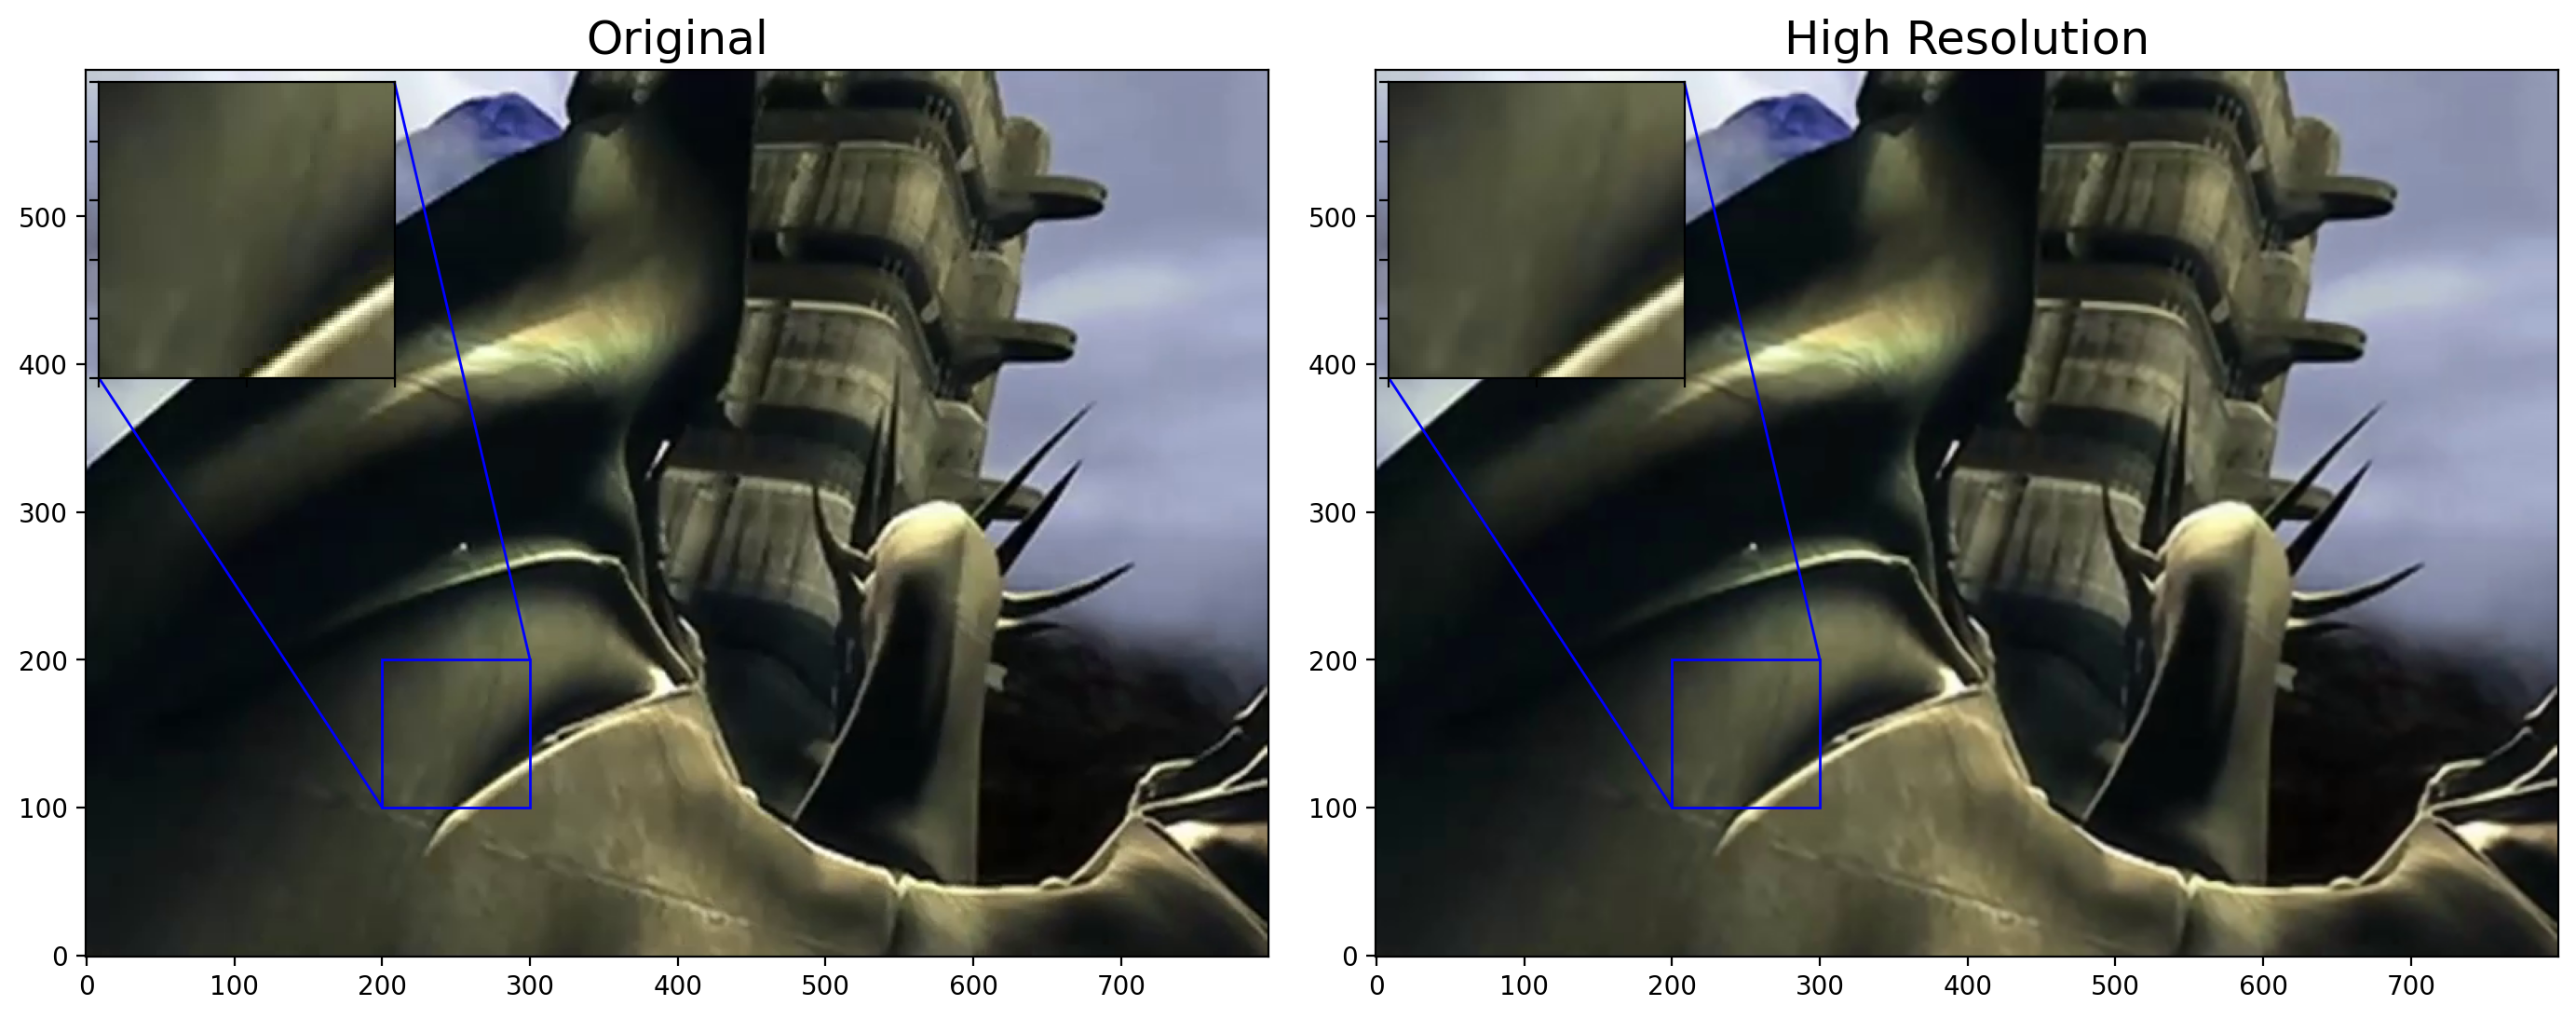

Can't read frame
Avg. PSNR of low resolution images is 	36.9763
Avg. PSNR of ESPCN reconstruction is 	40.0040
Avg. SSIM of low resolution images is 	0.9786
Avg. SSIM of ESPCN reconstruction is 	0.9857


In [6]:
# Test the whole video
test_super_resolution(test_video=True, model='ESPCN')